**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob

%matplotlib inline

In [2]:
def readImages(imageNames):
    images = []
    for imgName in imageNames:
        img = cv2.imread(imgName)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append(img)
    return images


car_images = glob.glob('training/vehicles/vehicles/**/*.png')
noncar_images = glob.glob('training/non-vehicles/non-vehicles/**/*.png')     

cars = readImages(car_images)
notcars = readImages(noncar_images)
print(len(car_images), len(noncar_images))

8792 8968


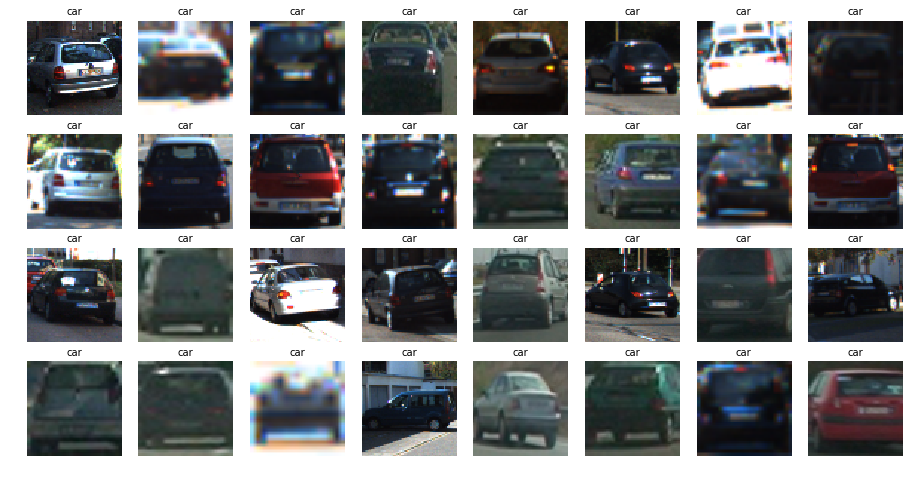

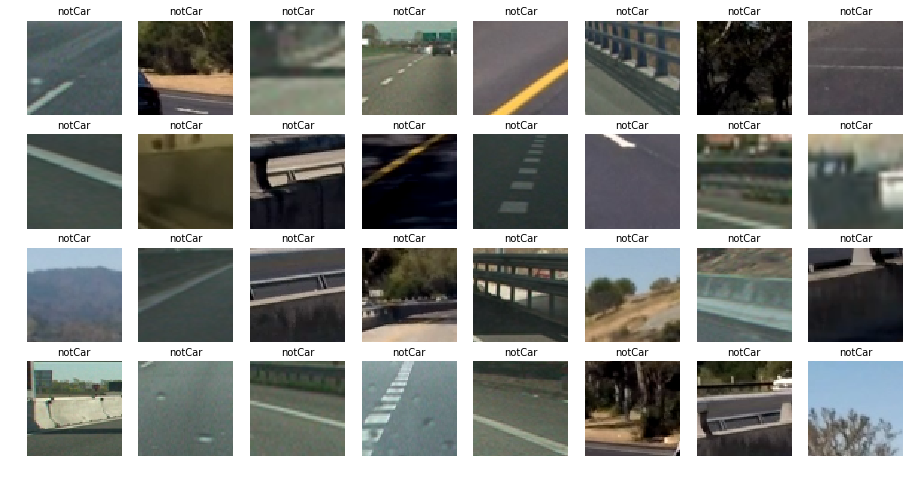

In [3]:

fig,  axs  =  plt.subplots(4,8, figsize=(16,8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cars[np.random.randint(0,len(car_images))]
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
    
plt.savefig('carSamples.png', bbox_inches="tight")

fig,  axs  =  plt.subplots(4,8, figsize=(16,8))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
    
for i in np.arange(32):
    img = notcars[np.random.randint(0,len(noncar_images))]
    axs[i].axis('off')
    axs[i].set_title('notCar', fontsize=10)
    axs[i].imshow(img)
    
plt.savefig('notCarSamples.png', bbox_inches="tight")

### HOG and color historgram

In [4]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler


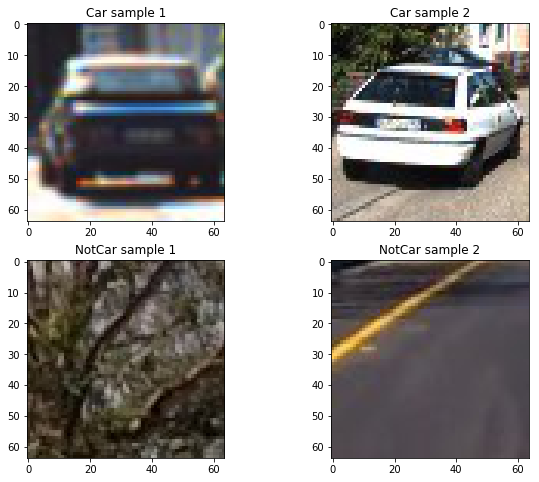

In [5]:
testCarImag1_name = 'training/vehicles_smallset/cars1/' + '1.jpeg'
testCarImag2_name = 'training/vehicles_smallset/cars1/' + '17.jpeg'

img = cv2.imread(testCarImag1_name)
testCarImag1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.imread(testCarImag2_name)
testCarImag2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

testNotCarImag1_name = 'training/non-vehicles_smallset/notcars1/' + 'extra64.jpeg'
testNotCarImag2_name = 'training/non-vehicles_smallset/notcars1/' + 'extra119.jpeg'

img = cv2.imread(testNotCarImag1_name)
testNotCarImag1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.imread(testNotCarImag2_name)
testNotCarImag2 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10,8))
plt.subplot(221)
plt.imshow(testCarImag1)
plt.title("Car sample 1")

plt.subplot(222)
plt.imshow(testCarImag2)
plt.title("Car sample 2")
plt.subplot(223)
plt.imshow(testNotCarImag1)
plt.title("NotCar sample 1")
plt.subplot(224)
plt.imshow(testNotCarImag2)
plt.title("NotCar sample 2")

### Features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm = 'L1',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm = 'L1',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


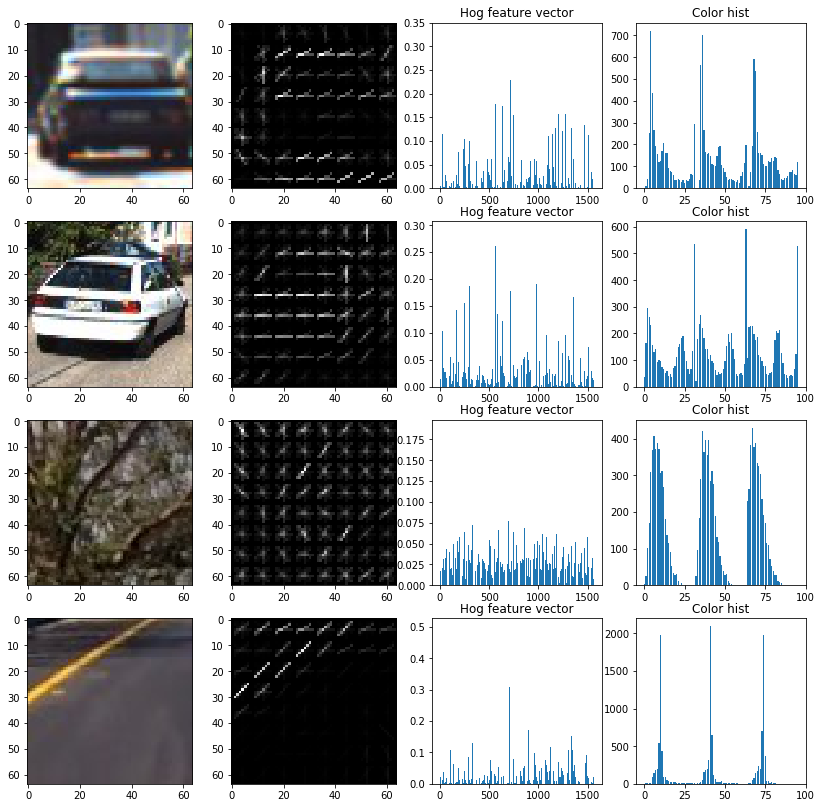

In [7]:
# plt.figure(1, figsize=[14,10])

fig,  axs  =  plt.subplots(4,4, figsize=(14, 14))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

for i, images in enumerate([testCarImag1, testCarImag2, testNotCarImag1, testNotCarImag2]):
    color_features = color_hist(images)
    
    hog_features, b = get_hog_features(cv2.cvtColor(images,cv2.COLOR_RGB2GRAY), 
                                       orient=8, pix_per_cell=8, cell_per_block=2, vis=True)

    aa = get_hog_features(cv2.cvtColor(images,cv2.COLOR_RGB2GRAY), 
                                       orient=8, pix_per_cell=8, cell_per_block=2, 
                                        vis=False, feature_vec=False)    
    
#     print(aa.shape)
    
    axs[i*4+0].imshow(images, cmap='gray')   

    axs[i*4+1].imshow(b, cmap='gray')
    
    axs[i*4+2].bar(range(7*7*2*2*8), hog_features)
    axs[i*4+2].set_title('Hog feature vector')
#     print(hog_features.shape)
    
    axs[i*4+3].bar(range(3*32), color_features)
    axs[i*4+3].set_title('Color hist')
    
plt.savefig('FeatureMaps.png', bbox_inches="tight")

In [8]:
def extract_features(images, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='Gray',
                        spatial_feat=True, hist_feat=True, hog_feat=True):  
    features = []
    for img in images:
        single_feature = single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        features.append(single_feature)
    return features
        

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
#     grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
#         elif hog_channel == 'Gray':
#             hog_features = get_hog_features(grayImage, orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [9]:
class ParameterSet():
    def __init__(self,colorspace, orient, pix_per_cell, cell_per_block 
                , hog_channel, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat):
        self.colorspace = colorspace # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat # Spatial features on or off
        self.hist_feat = hist_feat # Histogram features on or off
        self.hog_feat = hog_feat # HOG features on or off

myParameter = ParameterSet('YUV', 11, 16, 2, 'ALL', (32, 32), 32, False, False, True)
# myParameter = ParameterSet('YUV', 11, 16, 2, 'ALL', (16, 16), 32, True, True, True)


In [10]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split


print(len(cars), len(notcars))

# TODO play with these values to see how your classifier
# performs under different binning scenarios


colorspace = myParameter.colorspace
orient = myParameter.orient
pix_per_cell = myParameter.pix_per_cell
cell_per_block = myParameter.cell_per_block
hog_channel = myParameter.hog_channel
spatial_size = myParameter.spatial_size
hist_bins = myParameter.hist_bins
spatial_feat = myParameter.spatial_feat
hist_feat = myParameter.hist_feat
hog_feat = myParameter.hog_feat


car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
np.random.seed(20180610)
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test

if(spatial_feat + hist_feat + hog_feat) > 1:
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

print('size of data', len(X_train), len(X_test))

print('Using spatial binning of:',spatial_size,
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

8792 8968


/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


size of data 14208 3552
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 1188
0.6 Seconds to train SVC...
Test Accuracy of SVC =  0.9865


### sliding window

In [11]:
# Basic functions provided on Udacity's course to creating windows and drawing boxes on an image.
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [12]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = np.array(features).reshape(1, -1)

        if(spatial_feat + hist_feat + hog_feat) > 1:
            test_features = scaler.transform(test_features)
    
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


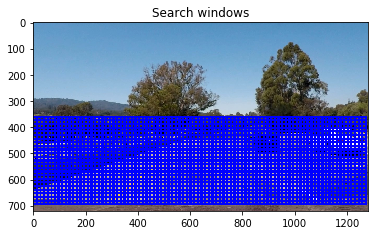

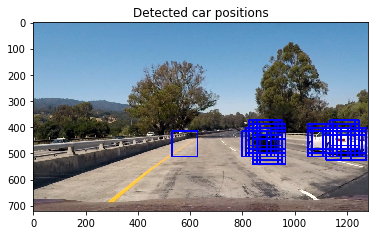

In [13]:
y_start_stop = [360, 700] # Min and max in y to search in slide_window()

colorspace = myParameter.colorspace
orient = myParameter.orient
pix_per_cell = myParameter.pix_per_cell
cell_per_block = myParameter.cell_per_block
hog_channel = myParameter.hog_channel
spatial_size = myParameter.spatial_size
hist_bins = myParameter.hist_bins
spatial_feat = myParameter.spatial_feat
hist_feat = myParameter.hist_feat
hog_feat = myParameter.hog_feat


image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.85, 0.85))

imgcopy = draw_boxes(image, windows, color=(0, 0, 255), thick=6)

plt.figure()
plt.imshow(imgcopy)
plt.title('Search windows')

plt.savefig('windows_method1.png', bbox_inches="tight")


hot_windows = search_windows(image, windows, svc, scaler=X_scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
plt.imshow(window_img)
plt.title('Detected car positions')

plt.savefig('detections_method1.png', bbox_inches="tight")


### Hog Sub-sampling Window Search

In [14]:
def HogSub_search_windows(img, scale, svc, X_scaler, color_space='RGB', 
                        x_start_stop=[None, None], y_start_stop=[None, None],
                        spatial_size=(32, 32), hist_bins=32, 
                        hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, 
                        hog_channel=0, spatial_feat=True, 
                        hist_feat=True, hog_feat=True, getAll = True):   
    

    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)    
        
    ystart =y_start_stop[0]
    ystop = y_start_stop[1]
    xstart =x_start_stop[0]
    xstop =x_start_stop[1]
        
    
    ctrans_tosearch = feature_image[ystart:ystop,xstart:xstop,:]

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(ctrans_tosearch[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, feature_vec=False))
        else:
            hog_features.append(get_hog_features(ctrans_tosearch[:,:,hog_channel], 
                                                 orient, pix_per_cell, cell_per_block, feature_vec=False))
    
    boxes = []
            
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            all_features = []
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                all_features.append(spatial_features)
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                all_features.append(hist_features)    
            
            if hog_feat == True:
                subHog_features = []
                if hog_channel == 'ALL':
                    for channel in range(feature_image.shape[2]):
                        subHog = hog_features[channel][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                        subHog_features.extend(subHog)
                else:
                    subHog = hog_features[0][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    subHog_features = subHog        
        
                all_features.append(subHog_features)

                
            all_features = np.concatenate(all_features)

            # Scale features and make a prediction
            if(spatial_feat + hist_feat + hog_feat) > 1:
                test_features = X_scaler.transform(all_features.reshape(1, -1))
            else:
                test_features = all_features.reshape(1, -1)
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            

            
            if test_prediction == 1 or getAll == True:
#                 print('test prediction', test_prediction, getAll)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                boxes.append(((xbox_left+xstart, ytop_draw+ystart),
                              (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))

    return boxes

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


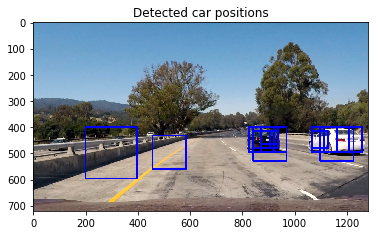

In [15]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# draw_image = np.copy(image)


colorspace = myParameter.colorspace
orient = myParameter.orient
pix_per_cell = myParameter.pix_per_cell
cell_per_block = myParameter.cell_per_block
hog_channel = myParameter.hog_channel
spatial_size = myParameter.spatial_size
hist_bins = myParameter.hist_bins
spatial_feat = myParameter.spatial_feat
hist_feat = myParameter.hist_feat
hog_feat = myParameter.hog_feat

xstart = 200
xstop = image.shape[1]

ystarts = [400, 416, 400, 432, 400, 432, 400, 464]
ystops = [464, 480, 496, 528, 528, 560, 596, 660]


windows = []

for ystart, ystop in zip(ystarts, ystops):
    
    scale = (ystop - ystart)/64

    ww = HogSub_search_windows(image, scale, svc, X_scaler, color_space=colorspace, 
                    x_start_stop=[xstart, xstop], y_start_stop=[ystart, ystop],
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, getAll = True)
    
    for it in ww:
        windows.append(it)
        
imgcopy = draw_boxes(image, windows, color=(0, 0, 255), thick=6)

plt.imshow(imgcopy)
plt.title('Search windows')

plt.savefig('windows_method2.png', bbox_inches="tight")

windows = []

for ystart, ystop in zip(ystarts, ystops):
    
    scale = (ystop - ystart)/64

    ww = HogSub_search_windows(image, scale, svc, X_scaler, color_space=colorspace, 
                    x_start_stop=[xstart, xstop], y_start_stop=[ystart, ystop],
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    hist_range=(0, 256), orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, getAll = False)
    
    for it in ww:
        windows.append(it)
        
imgcopy = draw_boxes(image, windows, color=(0, 0, 255), thick=6)

plt.imshow(imgcopy)
plt.title('Detected car positions')

plt.savefig('detections_method2.png', bbox_inches="tight")

# plt.savefig('badDetection.png', bbox_inches="tight")

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



2  car found


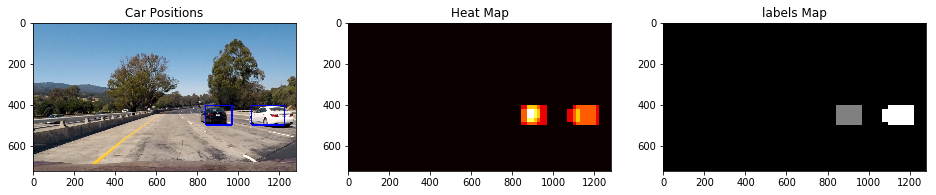

In [17]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

print(labels[1], ' car found')

fig = plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(labels[0], cmap='gray')
plt.title('labels Map')
# fig.tight_layout()

# plt.savefig(saveFigName, bbox_inches="tight")

plt.savefig('heapMap.png', bbox_inches="tight")

## Image processing pipeline

In [18]:
def process_frame(image):

    colorspace = myParameter.colorspace
    orient = myParameter.orient
    pix_per_cell = myParameter.pix_per_cell
    cell_per_block = myParameter.cell_per_block
    hog_channel = myParameter.hog_channel
    spatial_size = myParameter.spatial_size
    hist_bins = myParameter.hist_bins
    spatial_feat = myParameter.spatial_feat
    hist_feat = myParameter.hist_feat
    hog_feat = myParameter.hog_feat
    
#     print(colorspace,orient,pix_per_cell,spatial_feat,hist_feat,hog_feat)

    xstart = 200
    xstop = image.shape[1]

    ystarts = [400, 416, 400, 432, 400, 432, 400, 464]
    ystops = [464, 480, 496, 528, 528, 560, 596, 660]
    
    windows=[]

    for ystart, ystop in zip(ystarts, ystops):

        scale = (ystop - ystart)/64
        
        ww = HogSub_search_windows(image, scale, svc, X_scaler, color_space=colorspace, 
                        x_start_stop=[xstart, xstop], y_start_stop=[ystart, ystop],
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, getAll = False)

        for it in ww:
            windows.append(it)

            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)            

    return draw_img

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


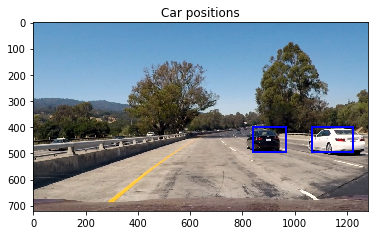

In [19]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
draw_img = process_frame(image)
plt.imshow(draw_img)
plt.title('Car positions')
# plt.show()

plt.savefig('oneImage_pipeLine.png', bbox_inches="tight")

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


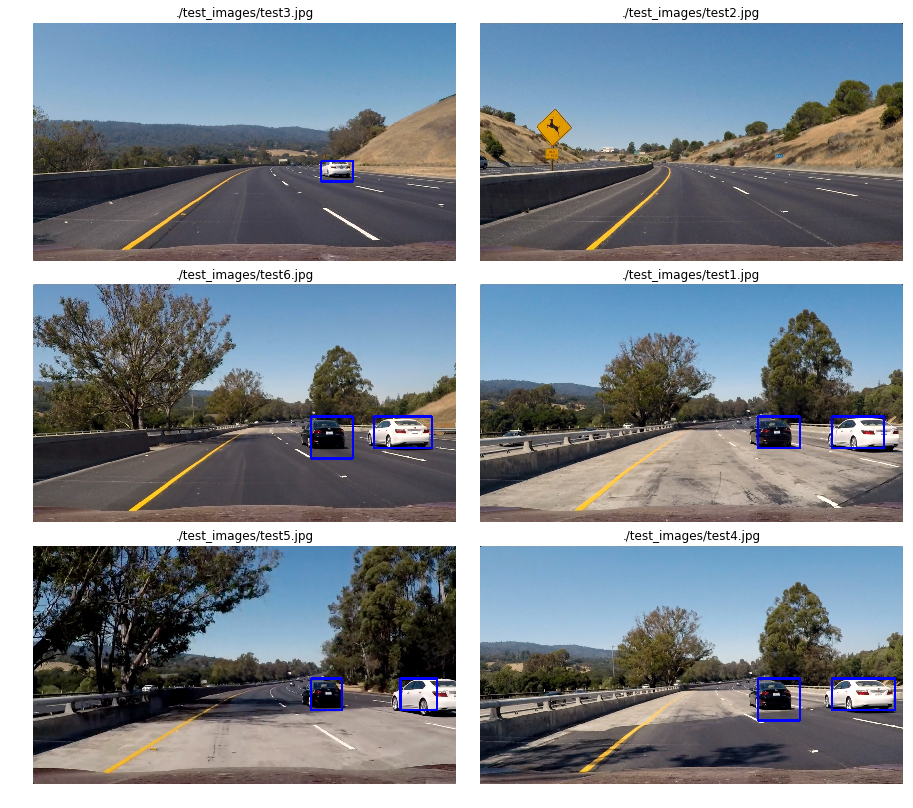

In [20]:
test_images  = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .1, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    image = cv2.imread(im)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    axs[i].imshow(process_frame(image))
    axs[i].set_title(im)
    axs[i].axis('off')
    
plt.savefig('sixImage_pipeLine.png', bbox_inches="tight")

### video pipline

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
from collections import deque

# Define a class to store data from video# Define  
class FrameDetectSequence():
    def __init__(self):
        # history of rectangles previous n frames
        self.prevDetects = [] 
        
    def addWindows(self, windows):
        self.prevDetects.append(windows)
        if len(self.prevDetects) > 15:
            # throw out oldest rectangle set(s)
            self.prevDetects = self.prevDetects[len(self.prevDetects)-10:]

print('...')

...


In [23]:
def video_process_frame(image): 

    colorspace = myParameter.colorspace
    orient = myParameter.orient
    pix_per_cell = myParameter.pix_per_cell
    cell_per_block = myParameter.cell_per_block
    hog_channel = myParameter.hog_channel
    spatial_size = myParameter.spatial_size
    hist_bins = myParameter.hist_bins
    spatial_feat = myParameter.spatial_feat
    hist_feat = myParameter.hist_feat
    hog_feat = myParameter.hog_feat
    
#     print(colorspace,orient,pix_per_cell,spatial_feat,hist_feat,hog_feat)

    xstart = 200
    xstop = image.shape[1]

    ystarts = [400, 416, 400, 432, 400, 432, 400, 464]
    ystops = [464, 480, 496, 528, 528, 560, 596, 660]
    
    windows=[]

    for ystart, ystop in zip(ystarts, ystops):

        scale = (ystop - ystart)/64
        
        ww = HogSub_search_windows(image, scale, svc, X_scaler, color_space=colorspace, 
                        x_start_stop=[xstart, xstop], y_start_stop=[ystart, ystop],
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, getAll = False)

        for it in ww:
            windows.append(it)

    # add windows to the history
    if len(windows) > 0:
        detectSequence.addWindows(windows)
    
    heatmap_img = np.zeros_like(image[:,:,0]).astype(np.float)
    for wind in detectSequence.prevDetects:
        heatmap_img = add_heat(heatmap_img, wind)
    heatmap_img = apply_threshold(heatmap_img, 1 + int(len(detectSequence.prevDetects) * 0.8) )


    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatmap_img, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)


    return draw_img

In [24]:
detectSequence = FrameDetectSequence()

test_out_file  = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(video_process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:06<00:00,  5.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 33.7 s, sys: 132 ms, total: 33.9 s
Wall time: 7.4 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [26]:

detectSequence = FrameDetectSequence()

project_video_out_file  = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(video_process_frame)
%time clip_test_out.write_videofile(project_video_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [04:03<00:00,  5.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 20min 42s, sys: 2.38 s, total: 20min 45s
Wall time: 4min 3s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_out_file))